<a href="https://colab.research.google.com/github/RohithReddyThumma/IST597_Fall2019_TF2.0/blob/master/LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>>> Baseline (no normalization)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3 | loss: 0.5405 | acc: 80.82%
Epoch 2/3 | loss: 0.3466 | acc: 87.82%
Epoch 3/3 | loss: 0.3054 | acc: 89.25%
Test Accuracy after training: 88.64%
Time elapsed: 305.4s

>>> BatchNorm
Epoch 1/3 | loss: 0.4196 | acc: 85.21%
Epoch 2/3 | loss: 0.2898 | acc: 89.68%
Epoch 3/3 | loss: 0.2527 | acc: 91.02%
Test Accuracy after training: 90.50%
Time elapsed: 898.5s

>>> LayerNorm
Epoch 1/3 | loss: 0.4159 | acc: 84.99%
Epoch 2/3 | loss: 0.2881 | acc: 89.67%
Epoch 3/3 | loss: 0.2523 | acc: 90.95%
Test Accuracy after training: 90.83%
Time elapsed: 827.7s

>>> WeightNorm
Epoch 1/3 | loss: 0.7388 | acc: 74.30%
Epoch 2/3 | loss: 0.4864 | acc: 82.62%
Epoch 3/3 | loss: 0.4454 | acc: 84.32%
Test Accuracy after training: 84.34%
Time elapsed: 322.4s



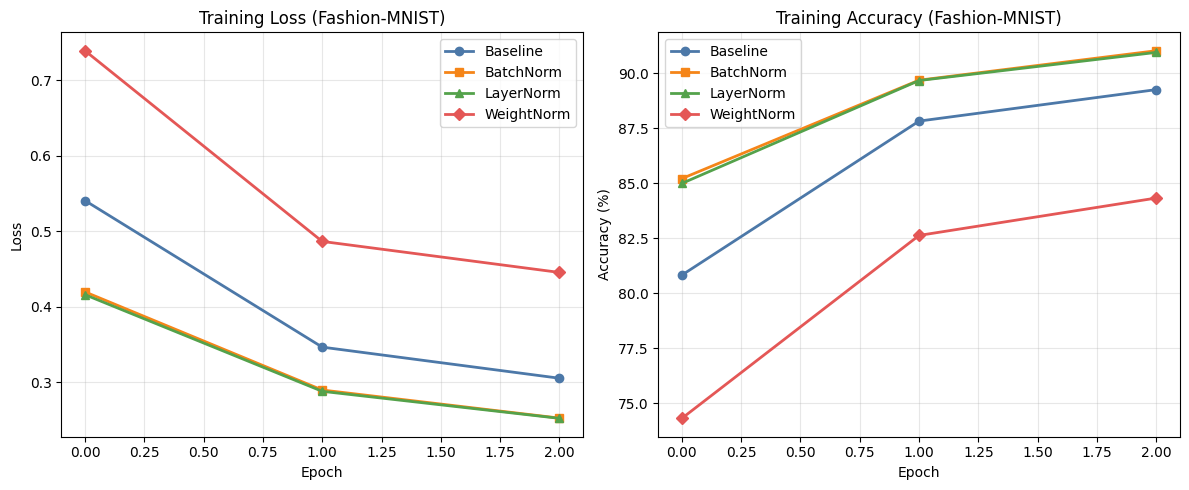

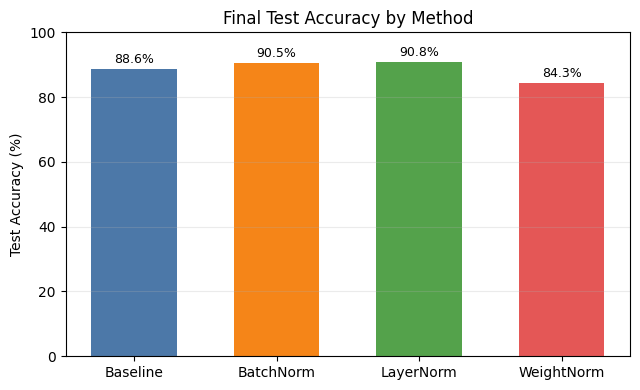

In [2]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

# ================================
# Custom Normalization Functions
# ================================
def batch_norm_custom(x, gamma, beta, axis=[0, 1, 2], eps=1e-5):
    mean = tf.reduce_mean(x, axis=axis, keepdims=True)
    var  = tf.reduce_mean((x - mean) ** 2, axis=axis, keepdims=True)
    x_norm = (x - mean) / tf.sqrt(var + eps)
    return gamma * x_norm + beta, mean, var

def layer_norm_custom(x, gamma, beta, eps=1e-5):
    # Per-sample LN across H,W,C
    mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    var  = tf.reduce_mean((x - mean) ** 2, axis=[1, 2, 3], keepdims=True)
    x_norm = (x - mean) / tf.sqrt(var + eps)
    return gamma * x_norm + beta

def weight_norm_custom(w, eps=1e-5):
    # Simple scalar-norm version (keeps behavior similar to your script)
    g = tf.norm(w)
    w_norm = w / (g + eps)
    return w_norm, g

# ================================
# CNN Model with Normalizations
# ================================
class CNN(tf.keras.Model):
    def __init__(self, use_batchnorm=False, use_layernorm=False, use_weightnorm=False):
        super().__init__()
        self.use_batchnorm = use_batchnorm
        self.use_layernorm = use_layernorm
        self.use_weightnorm = use_weightnorm

        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation=None, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation=None, padding='same')
        self.pool  = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(10)

        # Custom gamma/beta for BatchNorm (per-channel tensors shaped for broadcasting)
        if self.use_batchnorm:
            self.gamma_conv1 = tf.Variable(tf.ones([1, 1, 1, 32]), trainable=True)
            self.beta_conv1  = tf.Variable(tf.zeros([1, 1, 1, 32]), trainable=True)
            self.gamma_conv2 = tf.Variable(tf.ones([1, 1, 1, 64]), trainable=True)
            self.beta_conv2  = tf.Variable(tf.zeros([1, 1, 1, 64]), trainable=True)

        # Custom gamma/beta for LayerNorm (scalar broadcast, same as your script)
        if self.use_layernorm:
            self.gamma_ln = tf.Variable(tf.ones([1, 1, 1, 1]), trainable=True)
            self.beta_ln  = tf.Variable(tf.zeros([1, 1, 1, 1]), trainable=True)

    def call(self, x, training=False):
        # ----- Conv1 -----
        if self.use_weightnorm:
            if not self.conv1.built:
                _ = self.conv1(x)
            w_norm, _ = weight_norm_custom(self.conv1.kernel)
            conv1_out = tf.nn.conv2d(x, w_norm, strides=[1, 1, 1, 1], padding='SAME')
            conv1_out = tf.nn.bias_add(conv1_out, self.conv1.bias)
        else:
            conv1_out = self.conv1(x)

        if self.use_batchnorm:
            conv1_out, _, _ = batch_norm_custom(conv1_out, self.gamma_conv1, self.beta_conv1)
        elif self.use_layernorm:
            conv1_out = layer_norm_custom(conv1_out, self.gamma_ln, self.beta_ln)

        conv1_act  = tf.nn.relu(conv1_out)
        conv1_pool = self.pool(conv1_act)

        # ----- Conv2 -----
        if self.use_weightnorm:
            if not self.conv2.built:
                _ = self.conv2(conv1_pool)
            w_norm2, _ = weight_norm_custom(self.conv2.kernel)
            conv2_out = tf.nn.conv2d(conv1_pool, w_norm2, strides=[1, 1, 1, 1], padding='SAME')
            conv2_out = tf.nn.bias_add(conv2_out, self.conv2.bias)
        else:
            conv2_out = self.conv2(conv1_pool)

        if self.use_batchnorm:
            conv2_out, _, _ = batch_norm_custom(conv2_out, self.gamma_conv2, self.beta_conv2)
        elif self.use_layernorm:
            conv2_out = layer_norm_custom(conv2_out, self.gamma_ln, self.beta_ln)

        conv2_act  = tf.nn.relu(conv2_out)
        conv2_pool = self.pool(conv2_act)

        flat = self.flatten(conv2_pool)
        logits = self.fc(flat)
        return logits

# ================================
# Training Function
# ================================
def train_model(use_batchnorm=False, use_layernorm=False, use_weightnorm=False,
                epochs=3, batch_size=128, lr=1e-3, seed=42):
    # Dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train[..., None] / 255.0
    x_test  = x_test[..., None]  / 255.0

    tf.keras.utils.set_random_seed(seed)
    model = CNN(use_batchnorm, use_layernorm, use_weightnorm)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                              .shuffle(10000, seed=seed) \
                              .batch(batch_size) \
                              .prefetch(tf.data.AUTOTUNE)

    history = {'loss': [], 'acc': [], 'test_acc': None}
    start = time.time()

    for epoch in range(epochs):
        epoch_losses = []
        epoch_accs = []
        for batch_x, batch_y in train_ds:
            with tf.GradientTape() as tape:
                logits = model(batch_x, training=True)
                loss = loss_fn(batch_y, logits)
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))

            preds = tf.argmax(logits, axis=1)
            acc = np.mean(preds.numpy() == batch_y.numpy())
            epoch_losses.append(loss.numpy())
            epoch_accs.append(acc)

        avg_loss = float(np.mean(epoch_losses))
        avg_acc  = float(np.mean(epoch_accs))
        history['loss'].append(avg_loss)
        history['acc'].append(avg_acc)
        print(f"Epoch {epoch+1}/{epochs} | loss: {avg_loss:.4f} | acc: {avg_acc*100:.2f}%")

    # Test accuracy
    logits_test = model(x_test, training=False)
    preds_test = tf.argmax(logits_test, axis=1)
    test_acc = float(np.mean(preds_test.numpy() == y_test))
    history['test_acc'] = test_acc
    print(f"Test Accuracy after training: {test_acc*100:.2f}%")
    print(f"Time elapsed: {time.time()-start:.1f}s\n")
    return model, history

# ================================
# Plotting (Custom Colors)
# ================================
def plot_training_curves(histories, labels, title_suffix="Fashion-MNIST"):
    """
    Uses a colorblind-friendly palette + distinct markers.
    """
    # Color palette for each label
    palette = {
        "Baseline":   "#4C78A8",  # blue
        "BatchNorm":  "#F58518",  # orange
        "LayerNorm":  "#54A24B",  # green
        "WeightNorm": "#E45756",  # red
    }
    # Fallback colors if label not in palette
    default_colors = ["#4C78A8", "#F58518", "#54A24B", "#E45756", "#72B7B2", "#B279A2"]

    # Markers per series
    markers = {
        "Baseline":   "o",
        "BatchNorm":  "s",
        "LayerNorm":  "^",
        "WeightNorm": "D",
    }
    default_markers = ["o", "s", "^", "D", "v", "*"]

    plt.figure(figsize=(12, 5))

    # ---- Loss ----
    plt.subplot(1, 2, 1)
    for idx, (h, lab) in enumerate(zip(histories, labels)):
        color = palette.get(lab, default_colors[idx % len(default_colors)])
        marker = markers.get(lab, default_markers[idx % len(default_markers)])
        plt.plot(h['loss'], label=lab, color=color, marker=marker, linewidth=2, markersize=6)
    plt.title(f"Training Loss ({title_suffix})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.legend()

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    for idx, (h, lab) in enumerate(zip(histories, labels)):
        color = palette.get(lab, default_colors[idx % len(default_colors)])
        marker = markers.get(lab, default_markers[idx % len(default_markers)])
        plt.plot(np.array(h['acc']) * 100, label=lab, color=color, marker=marker, linewidth=2, markersize=6)
    plt.title(f"Training Accuracy ({title_suffix})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_test_bars(histories, labels):
    """Optional: bar chart of final test accuracy with same colors."""
    palette = {
        "Baseline":   "#4C78A8",
        "BatchNorm":  "#F58518",
        "LayerNorm":  "#54A24B",
        "WeightNorm": "#E45756",
    }
    colors = [palette.get(l, "#4C78A8") for l in labels]
    test_accs = [h.get('test_acc', 0.0) * 100 for h in histories]

    plt.figure(figsize=(6.5, 4))
    xs = np.arange(len(labels))
    plt.bar(xs, test_accs, color=colors, width=0.6)
    plt.xticks(xs, labels)
    plt.ylabel("Test Accuracy (%)")
    plt.title("Final Test Accuracy by Method")
    plt.ylim(0, 100)
    plt.grid(axis="y", alpha=0.25)
    for i, v in enumerate(test_accs):
        plt.text(i, v + 1.0, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

# ================================
# Main
# ================================
if __name__ == "__main__":
    histories = []
    labels = []

    print(">>> Baseline (no normalization)")
    _, h1 = train_model(False, False, False)
    histories.append(h1); labels.append("Baseline")

    print(">>> BatchNorm")
    _, h2 = train_model(True,  False, False)
    histories.append(h2); labels.append("BatchNorm")

    print(">>> LayerNorm")
    _, h3 = train_model(False, True,  False)
    histories.append(h3); labels.append("LayerNorm")

    print(">>> WeightNorm")
    _, h4 = train_model(False, False, True)
    histories.append(h4); labels.append("WeightNorm")

    # Plots with new colors
    plot_training_curves(histories, labels, title_suffix="Fashion-MNIST")
    plot_test_bars(histories, labels)